In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from tqdm import tqdm

import sys
sys.path.append('/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_model/')
from optimize_dynamic_model import get_binary_input_patterns

%matplotlib inline

In [2]:
class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        self.ffi_size = 7
        
        super().__init__()

        self.out_in  = nn.Linear(self.input_size, self.output_size)
        self.ffi_in  = nn.Linear(self.input_size, self.ffi_size)
        self.out_ffi = nn.Linear(self.ffi_size, self.output_size)
        
#         # Initialize weights to positive values
#         self.out_in.weight.data = self.out_in.weight.data.uniform_(0, 1)
#         self.ffi_in.weight.data = self.ffi_in.weight.data.uniform_(0, 1)
#         self.out_ffi.weight.data = self.out_ffi.weight.data.uniform_(-0.1, 0)

        self.out_in.bias.data.uniform_(3,3)
                        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    
    def forward(self, input_pattern):
        out1 = self.out_in(input_pattern)
        
        out2 = self.ffi_in(input_pattern)
        out2 = self.out_ffi(out2)
        
        output = out1 + out2
        output = F.relu(output)
        return output
    
    def forward_linear(self, input_pattern):
        out1 = self.out_in(input_pattern)
        out2 = self.ffi_in(input_pattern)
        out2 = self.out_ffi(out2)
        output = out1 + out2
        return output
    
    
    def train(self,epochs,all_patterns):
        losses = []
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            
            pattern_index = np.random.randint(0,128)
            input_pattern = all_patterns[pattern_index]
            
            output = self.forward(input_pattern)
            target = torch.eye(128)[pattern_index]
            
            non_target_idx = [x for x in range(128) if x!=pattern_index]
            non_target_loss = torch.mean(output[non_target_idx]**2)
            target_loss = 1/(output[pattern_index]+0.01)
            loss = target_loss + non_target_loss
            
            losses.append(loss.detach())
            loss.backward()
            self.optimizer.step()
            
        return losses

In [3]:
# Create network
dentate_net = dentate_network(lr=0.0002)
all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)

In [4]:
# Save initial state
w_init = {'out_in': dentate_net.out_in.weight.detach().numpy().flatten(),
          'ffi_in': dentate_net.ffi_in.weight.detach().numpy().flatten(),
          'out_ffi': dentate_net.out_ffi.weight.detach().numpy().flatten()}

b_init = {'out_in': dentate_net.out_in.bias.detach().numpy().flatten(),
          'ffi_in': dentate_net.ffi_in.bias.detach().numpy().flatten(),
          'out_ffi': dentate_net.out_ffi.bias.detach().numpy().flatten()}

output_init = []
for pattern in all_patterns:
    output_init.append(list(dentate_net.forward(pattern).detach()))
output_init = np.array(output_init)

In [5]:
# Train network
epochs = 5*10**5
losses = dentate_net.train(epochs, all_patterns)

100%|██████████| 500000/500000 [03:50<00:00, 2168.90it/s]


In [6]:
# Save final state
w_final = {'out_in': dentate_net.out_in.weight.detach().numpy().flatten(),
          'ffi_in': dentate_net.ffi_in.weight.detach().numpy().flatten(),
          'out_ffi': dentate_net.out_ffi.weight.detach().numpy().flatten()}

b_final = {'out_in': dentate_net.out_in.bias.detach().numpy().flatten(),
          'ffi_in': dentate_net.ffi_in.bias.detach().numpy().flatten(),
          'out_ffi': dentate_net.out_ffi.bias.detach().numpy().flatten()}

output_final = []
for pattern in all_patterns:
    output_final.append(list(dentate_net.forward(pattern).detach()))
output_final = np.array(output_final)

output_final_linear = []
for pattern in all_patterns:
    output_final_linear.append(list(dentate_net.forward_linear(pattern).detach()))
output_final_linear = np.array(output_final_linear)

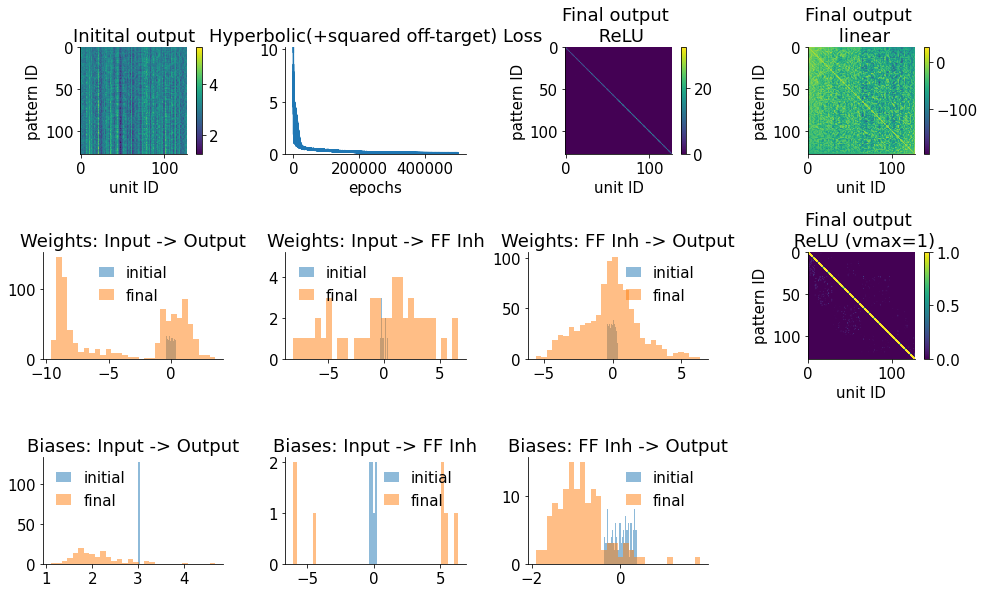

In [12]:
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(14,8.5))
axes = gs.GridSpec(nrows=3, ncols=12)
    
# Row 1: output activities
ax = fig.add_subplot(axes[0,0:3])
im = ax.imshow(output_init)
ax.set_title('Initital output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,3:6])
ax.plot(losses)
ax.set_xlabel('epochs')
ax.set_title('Hyperbolic(+squared off-target) Loss')
ax.set_ylim([0,np.max(losses)])
# ax.set_ylim([0,1])

ax = fig.add_subplot(axes[0,6:9])
im = ax.imshow(output_final)
ax.set_title('Final output \n ReLU')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[1,9:12])
im = ax.imshow(output_final,vmax=1)
ax.set_title('Final output \n ReLU (vmax=1)')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,9:12])
im = ax.imshow(output_final_linear)
ax.set_title('Final output \n linear')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)


# Row 2: weights
ax = fig.add_subplot(axes[1,0:3])
ax.hist(w_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,3:6])
ax.hist(w_init['ffi_in'],30,alpha=0.5,label='initial')
ax.hist(w_final['ffi_in'],30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> FF Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,6:9])
ax.hist(w_init['out_ffi'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_ffi'],30,alpha=0.5,label='final')
ax.set_title('Weights: FF Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


# Row 3: biases
ax = fig.add_subplot(axes[2,0:3])
ax.hist(b_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(b_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Biases: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,3:6])
ax.hist(b_init['ffi_in'],4,alpha=0.5,label='initial')
ax.hist(b_final['ffi_in'],50,alpha=0.5,label='final')
ax.set_title('Biases: Input -> FF Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[2,6:9])
ax.hist(b_init['out_ffi'],30,alpha=0.5,label='initial')
ax.hist(b_final['out_ffi'],30,alpha=0.5,label='final')
ax.set_title('Biases: FF Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


sns.despine()
fig.tight_layout()
plt.show()

name = "backprop_network_FFI_HyperbolicLoss_ReLU"
fig.savefig('../plots/'+name+'.png', edgecolor='white', dpi=300, facecolor='white', transparent=True)

In [8]:
np.max(output_final)

32.47629

In [9]:
np.max(output_final_linear)

32.47629

In [10]:
np.min(output_final_linear)

-196.40556